# Setting stuff up
Pick your favorite open pulse compatible backend

In [11]:
%matplotlib inline
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble

import qiskit
qiskit.__qiskit_version__
from qiskit.tools.jupyter import backend_overview, backend_monitor
from qiskit.tools.monitor import job_monitor
import numpy as np
import pickle
import matplotlib.pyplot as plotter
import time

In [12]:
from qiskit import IBMQ
## Put in your infor
# IBMQ.save_account()
IBMQ.load_account()

/anaconda3/envs/earnestq/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [13]:
def qubit_drive_freq_sweep(drive_duration=128,drive_strength=0.002,drive_qubits=[1],drive_span_MHz=20,drive_freq_steps_MHz=1.0,freq_shift_GHz=0.0):
    # drive pulse parameters
    drive_sigma = 16
    schedules = []
    schedule_LOs = []

    for ii,qubit in enumerate(drive_qubits):
        center_frequency_GHz = backend_defaults.qubit_freq_est[qubit]
        center_frequency_GHz = center_frequency_GHz - freq_shift_GHz
        print (center_frequency_GHz)
        frequency_min = center_frequency_GHz - drive_span_MHz/2.e3
        frequency_max = center_frequency_GHz + drive_span_MHz/2.e3
        frequencies_GHz = np.arange(frequency_min, frequency_max, drive_freq_steps_MHz/1e3)
        # creating drive pulse
        drive_pulse = pulse_lib.gaussian(duration=drive_duration, amp=drive_strength,
                                         sigma=drive_sigma, name='mydrivepulse')
        drive_pulse_qubit = drive_pulse(backend_devicespec.q[qubit].drive)



        # measurement pulse parameters
        meas_amp = 0.05
        meas_samples = 1200
        meas_sigma = 4
        meas_risefall = 25

        # creating measurement pulse
        meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                               sigma=meas_sigma, risefall=meas_risefall, 
                                               name='mymeasurepulse')
        meas_pulse_qubit = meas_pulse(backend_devicespec.q[qubit].measure)

        # create acquire pulse
        acq_cmd=pulse.Acquire(duration=meas_samples)
        acq_cmd_qubit = acq_cmd(backend_devicespec.q, backend_devicespec.mem)

        # combined measure and acquire pulse
        measure_and_acquire_qubit = meas_pulse_qubit | acq_cmd_qubit

        # scalefactor for received data
        scale_factor = 1e-10



        num_shots_per_frequency = 512
        for jj, drive_frequency in enumerate(frequencies_GHz):
            # start an empty schedule with a label
            this_schedule = pulse.Schedule(name="Frequency = {}".format(drive_frequency))
            this_schedule += drive_pulse_qubit
            this_schedule += measure_and_acquire_qubit << this_schedule.duration

            schedules.append(this_schedule)
            thisLO = pulse.LoConfig({backend_devicespec.q[qubit].drive: drive_frequency})
            schedule_LOs.append(thisLO)
        
    VNASweep_experiment_qobj = assemble(schedules, backend = backend, 
                            meas_level=1, meas_return='avg', 
                            shots=num_shots_per_frequency,
                            schedule_los = schedule_LOs
                            )
    return VNASweep_experiment_qobj, schedules, schedule_LOs

In [14]:
def qubit_rabi_pow_sweep(drive_duration=128,drive_start=0.005,drive_stop=0.05,drive_steps=0.005,drive_qubits=[1],drive_freq=5.0):
    # drive pulse parameters
    drive_sigma = 16
    Rabi_schedules = []
    Rabi_schedule_LOs = []
    for ii,qubit in enumerate(drive_qubits):
        drive_powers = np.arange(drive_start, drive_stop, drive_steps)
        # creating drive pulse
        drive_pulse = pulse_lib.gaussian(duration=drive_duration, amp=drive_start,
                                         sigma=drive_sigma, name='mydrivepulse')
        drive_pulse_qubit = drive_pulse(backend_devicespec.q[qubit].drive)



        # measurement pulse parameters
        meas_amp = 0.05
        meas_samples = 1200
        meas_sigma = 4
        meas_risefall = 25

        # creating measurement pulse
        meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                               sigma=meas_sigma, risefall=meas_risefall, 
                                               name='mymeasurepulse')
        meas_pulse_qubit = meas_pulse(backend_devicespec.q[qubit].measure)

        # create acquire pulse
        acq_cmd=pulse.Acquire(duration=meas_samples)
        acq_cmd_qubit = acq_cmd(backend_devicespec.q, backend_devicespec.mem)

        # combined measure and acquire pulse
        measure_and_acquire_qubit = meas_pulse_qubit | acq_cmd_qubit

        # scalefactor for received data
        scale_factor = 1e-10



        num_shots_per_frequency = 512
        for ii, drive_power in enumerate(drive_powers):
            rabi_pulse = pulse_lib.gaussian(duration=drive_duration, amp=drive_power, 
                                            sigma=drive_sigma, name='rabi_pulse_{}'.format(ii))
            rabi_pulse_qubit = rabi_pulse(backend_devicespec.q[qubit].drive)
            # start an empty schedule with a label
            this_schedule = pulse.Schedule(name="Rabi drive = {}".format(drive_power))
            this_schedule += rabi_pulse_qubit
            this_schedule += measure_and_acquire_qubit << this_schedule.duration

            Rabi_schedules.append(this_schedule)
            thisLO = pulse.LoConfig({backend_devicespec.q[qubit].drive: drive_freq})
            Rabi_schedule_LOs.append(thisLO)
        
    Rabi_power_qobj = assemble(Rabi_schedules, backend = backend, 
                            meas_level=1, meas_return='avg', 
                            shots=num_shots_per_frequency,
                            schedule_los = Rabi_schedule_LOs
                            )
    return Rabi_power_qobj, Rabi_schedules, Rabi_schedule_LOs

In [15]:
def T1_measurement(qubit=0, qubit_freq=1.0,pi_pulse_pow=0.2,pi_pulse_duration=128,time_max_us=500.0,time_step_us=2.0):
    # T1 experiment parameters
    drive_sigma = 6
    times_us = np.arange(1, time_max_us, time_step_us)
    num_shots_per_point = 512

    # drive parameters

    # create schedules for Ramsey experiment 
    T1_schedules = []
    T1_schedule_LOs = []

    T1_pulse = pulse_lib.gaussian(duration=pi_pulse_duration, amp=pi_pulse_pow, 
                                    sigma=drive_sigma, name='T1_pulse')
    T1_pulse_qubit = T1_pulse(backend_devicespec.q[qubit].drive)
    thisLO = pulse.LoConfig({backend_devicespec.q[qubit].drive: qubit_freq})
    for ii, delay_time_us in enumerate(times_us):
        # start an empty schedule with a label
        this_schedule = pulse.Schedule(name="T1 delay = {} us".format(qubit_freq))
        this_schedule += T1_pulse_qubit
        this_schedule |= (measure_and_acquire_qubit << int(delay_time_us*1000/dt))

        T1_schedules.append(this_schedule)
        T1_schedule_LOs.append(thisLO)

    T1_experiment_qobj = assemble (T1_schedules, backend = backend, 
                                meas_level=1, meas_return='avg',
                                shots=num_shots_per_point,
                                schedule_los = T1_schedule_LOs
                                    )
    return T1_experiment_qobj, T1_schedules, T1_schedule_LOs

In [16]:

# test_qobj, test_schedules, test_LO_schedules = qubit_rabi_pow_sweep(drive_steps=0.002)
# print (len(test_schedules))
# # np.arange(0.01, 0.05,0.007)


In [17]:
# test_num = 1
# test_schedules[20].draw(channels_to_plot=[backend_devicespec.q[test_num].measure, 
#                                            backend_devicespec.q[test_num].drive,
#                                            #backend_devicespec.q[qubit].acquire,
#                                          ],
#                                          scaling=10.0)

In [18]:
# IBMQ.provider()
provider = IBMQ.get_provider(hub='ibm-q-dev', group='support', project='default')

In [19]:
provider.backends()

[<IBMQBackend('ibmq_poughkeepsie') from IBMQ(hub='ibm-q-dev', group='support', project='default')>,
 <IBMQBackend('ibmq_boeblingen') from IBMQ(hub='ibm-q-dev', group='support', project='default')>,
 <IBMQBackend('ibmq_singapore') from IBMQ(hub='ibm-q-dev', group='support', project='default')>,
 <IBMQBackend('ibmq_almaden') from IBMQ(hub='ibm-q-dev', group='support', project='default')>,
 <IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-dev', group='support', project='default')>,
 <IBMQBackend('ibmq_rochester') from IBMQ(hub='ibm-q-dev', group='support', project='default')>,
 <IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-dev', group='support', project='default')>]

In [20]:
backend = provider.get_backend('ibmq_boeblingen')
backend_config = backend.configuration()

In [21]:
%qiskit_backend_monitor backend

UsageError: Line magic function `%qiskit_backend_monitor` not found.


In [22]:
backend_defaults = backend.defaults()
backend_devicespec = pulse.DeviceSpecification.create_from(backend)
dt = backend_config.dt

/anaconda3/envs/earnestq/lib/python3.7/site-packages/qiskit/pulse/channels/device_specification.py:46: DeprecationWarning: DeviceSpecification is deprecated.Instead of DeviceSpecification, use PulseChannelSpec.
  'Instead of DeviceSpecification, use PulseChannelSpec.', DeprecationWarning)


In [23]:
backend_defaults.qubit_freq_est[1]

4.8472947497933605

In [12]:
# Calculate amplitude from complex signal
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)

# 1. Find the qubit

Define the frequency range that will be swept in search of the qubit.

In [13]:
old_codes = ['5dc86e28bb6fd100115aacbc', '5dc86e2e0d505d0012dfe992', '5dc86e347820a700116595cb', '5dc86e3a0d505d0012dfe993', '5dc86e400d505d0012dfe994', '5dc86e457820a700116595cc', '5dc86e4b6c4dd90011508683', '5dc86e506c4dd90011508684', '5dc86e56bb6fd100115aacbe', '5dc86e5b6c4dd90011508685', '5dc86e610d505d0012dfe995', '5dc86e66867adf00111319b4', '5dc86e6cbb6fd100115aacc0', '5dc86e717820a700116595ce', '5dc86e776622b000110091f9', '5dc86e7c0d505d0012dfe996', '5dc86e8173c4410011ef04a9', '5dc86e877a1785001174c496', '5dc86e8c70b70d00122d0129', '5dc86e9270b70d00122d012b']

In [14]:
if False:
    print ("About to run")
    time.sleep(1)
    qubit_job_codes = []
    for i in range(20):
        sweep_qobj, schedules, schedule_LOs = qubit_drive_freq_sweep(drive_qubits=[i])
        time.sleep(0.1)
        job = backend.run(sweep_qobj)
        time.sleep(2)
        print (job.job_id())
        time.sleep(2)
        qubit_job_codes.append(job.job_id())
    print (qubit_job_codes)

In [15]:
job = backend.retrieve_job(qubit_job_codes[0])
VNASweep_results = job.result(timeout=3600)

NameError: name 'qubit_job_codes' is not defined

In [16]:
qubit = 18
job = backend.retrieve_job(old_codes[qubit])
VNASweep_results = job.result(timeout=3600)
drive_span_MHz=20
drive_freq_steps_MHz=1.0
center_frequency_GHz = backend_defaults.qubit_freq_est[qubit]
print (center_frequency_GHz)
center_frequency_GHz = center_frequency_GHz 
scale_factor=1.0

frequency_min = center_frequency_GHz - drive_span_MHz/2.e3
frequency_max = center_frequency_GHz + drive_span_MHz/2.e3
frequencies_GHz = np.arange(frequency_min, frequency_max, drive_freq_steps_MHz/1e3)
plot_X = frequencies_GHz
plot_Y = []
for kk, drive_frequency in enumerate(frequencies_GHz):
    thisfrequency_results = VNASweep_results.get_memory(kk)*scale_factor
    plot_Y.append( thisfrequency_results[qubit]  )

import matplotlib.pyplot as plotter
plotter.plot(plot_X, get_amplitude(plot_Y))
plotter.axvline(center_frequency_GHz)

4.752420191956177


ValueError: shapes (20,40) and (2,) not aligned: 40 (dim 1) != 2 (dim 0)

In [142]:
sweep_qobj, schedules, schedule_LOs = qubit_drive_freq_sweep(drive_strength=0.35,drive_qubits=[1],freq_shift_GHz=0.15)
backend_defaults.qubit_freq_est[1]

4.697297169266484


4.847297169266485

## Two photon process

In [144]:
twophoton_job_codes = []
for i in range(20):
    print (i)
    sweep_qobj, schedules, schedule_LOs = qubit_drive_freq_sweep(drive_strength=0.35,drive_qubits=[i],freq_shift_GHz=0.15)
    time.sleep(0.1)
    job = backend.run(sweep_qobj)
    time.sleep(2)
    print (job.job_id())
    time.sleep(2)
    twophoton_job_codes.append(job.job_id())
print (twophoton_job_codes)

0
4.896900365638736
5dcb09ca6c129f0011a81599
1
4.697297169266484
5dcb09d07069d20011460061
2
4.553656554150497
5dcb09d5491a8100123b25f6
3
4.624331194461392
5dcb09db491a8100123b25f7
4
4.216183279759661
5dcb09e1b3fed10012292945
5
4.761607192206396
5dcb09e61896660011bb283d
6
4.576867284366795
5dcb09ec5eb52e00110c5baf
7
4.396024207803126
5dcb09f22592de0011c9320d
8
4.508592808845852
5dcb09f72592de0011c9320e
9
4.616633465544842
5dcb09fd491a8100123b25f9
10
4.805298927928206
5dcb0a03684d760011534d5d
11
4.371705870615484
5dcb0a091896660011bb283f
12
4.582563137710962
5dcb0a0e1896660011bb2840
13
4.485560601622505
5dcb0a14b3fed10012292949
14
4.405080859933487
5dcb0a1a2592de0011c93210
15
4.432274241287666
5dcb0a20f2b4ea001160718e
16
4.605623987546261
5dcb0a26491a8100123b25fc
17
4.439829544070661
5dcb0a2bf2b4ea001160718f
18
4.602420191956177
5dcb0a310a67070011e8da76
19
4.885361892935842
5dcb0a365eb52e00110c5bb2
['5dcb09ca6c129f0011a81599', '5dcb09d07069d20011460061', '5dcb09d5491a8100123b25f6', '5dcb

In [18]:
tp_codes = ['5dc86f30bb6fd100115aacc1', '5dc86f356c4dd90011508689', '5dc86f3bbb6fd100115aacc2', '5dc86f416c4dd9001150868c', '5dc86f46de13de0011d5cc47', '5dc86f4bde13de0011d5cc49', '5dc86f5170b70d00122d012e', '5dc86f5770b70d00122d0130', '5dc86f5dbb6fd100115aacc4', '5dc86f62bb6fd100115aacc5', '5dc86f68de13de0011d5cc4b', '5dc86f6d70b70d00122d0131', '5dc86f737a1785001174c498', '5dc86f796c4dd9001150868f', '5dc86f7e867adf00111319bd', '5dc86f8473c4410011ef04b0', '5dc86f8a6622b000110091fd', '5dc86f8fbb6fd100115aacc6', '5dc86f9570b70d00122d0132', '5dc86f9a7a1785001174c499']

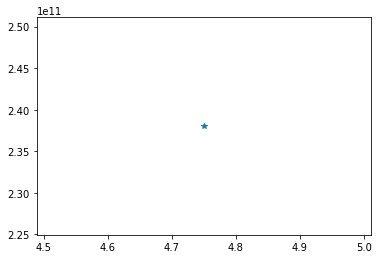

In [47]:
complex_vec = plot_Y[np.argmin(get_amplitude(plot_Y))]
freq = plot_X[np.argmin(get_amplitude(plot_Y))]
plotter.plot(freq,abs(complex_vec),"*")

The qubit 01 frequency is 4.589830
4.439829544070661


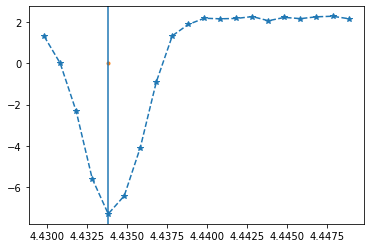

In [159]:
drive_freq_steps_MHz= 1.0
drive_span_MHz = 20.0
freq_shift_GHz = 0.15
qubit = -3
print ("The qubit 01 frequency is %f" %backend_defaults.qubit_freq_est[qubit])
job = backend.retrieve_job(twophoton_job_codes[qubit])
VNASweep_results = job.result(timeout=3600)


### . Getting the correct frequencies
center_frequency_GHz = backend_defaults.qubit_freq_est[qubit]
center_frequency_GHz = center_frequency_GHz - freq_shift_GHz
print (center_frequency_GHz)
frequency_min = center_frequency_GHz - drive_span_MHz/2.e3
frequency_max = center_frequency_GHz + drive_span_MHz/2.e3
frequencies_GHz = np.arange(frequency_min, frequency_max, drive_freq_steps_MHz/1e3)

## Back to the usual
plot_X = frequencies_GHz
plot_Y = []
for kk, drive_frequency in enumerate(frequencies_GHz):
    thisfrequency_results = VNASweep_results.get_memory(kk)*scale_factor
    plot_Y.append(  thisfrequency_results[qubit])  

import matplotlib.pyplot as plotter
plotter.plot(plot_X, get_amplitude(plot_Y),"--*")
complex_vec = plot_Y[np.argmin(get_amplitude(plot_Y))]
freq = plot_X[np.argmin(get_amplitude(plot_Y))]
two_photon_peak.append(freq)
plotter.plot(freq,get_amplitude(complex_vec),".")
plotter.axvline(freq)
# plotter.axvline(4.6950)

0
4.896900365638736
1
4.697297169266484
2
4.553656554150497
3
4.624331194461392
4
4.216183279759661
5
4.761607192206396
6
4.576867284366795
7
4.396024207803126
8
4.508592808845852
9
4.616633465544842
10
4.805298927928206
11
4.371705870615484
12
4.582563137710962
13
4.485560601622505
14
4.405080859933487
15
4.432274241287666
16
4.605623987546261
17
4.439829544070661
18
4.602420191956177
19
4.885361892935842


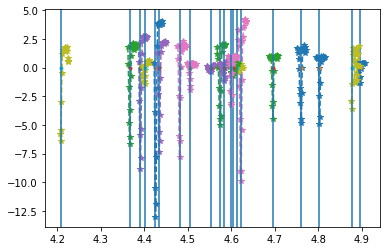

In [161]:
two_photon_peak = []
freq_shift_GHz = 0.15
for jj in range(20):
    qubit = jj
    print (qubit)
    job = backend.retrieve_job(twophoton_job_codes[qubit])
    VNASweep_results = job.result(timeout=3600)
    
    
    ### . Getting the correct frequencies
    center_frequency_GHz = backend_defaults.qubit_freq_est[qubit]
    center_frequency_GHz = center_frequency_GHz - freq_shift_GHz
    print (center_frequency_GHz)
    frequency_min = center_frequency_GHz - drive_span_MHz/2.e3
    frequency_max = center_frequency_GHz + drive_span_MHz/2.e3
    frequencies_GHz = np.arange(frequency_min, frequency_max, drive_freq_steps_MHz/1e3)
    
    ## Back to the usual
    plot_X = frequencies_GHz
    plot_Y = []
    for kk, drive_frequency in enumerate(frequencies_GHz):
        thisfrequency_results = VNASweep_results.get_memory(kk)*scale_factor
        plot_Y.append(  thisfrequency_results[qubit]  )

    import matplotlib.pyplot as plotter
    plotter.plot(plot_X, get_amplitude(plot_Y),"--*")
    complex_vec = plot_Y[np.argmin(get_amplitude(plot_Y))]
    freq = plot_X[np.argmin(get_amplitude(plot_Y))]
    two_photon_peak.append(freq)
    plotter.plot(freq,get_amplitude(complex_vec),".")
    plotter.axvline(freq)
    # plotter.axvline(4.6950)

In [26]:
testtest = [4.894900365638739, 4.695297169266487, 4.5526565541505, 4.621331194461394, 4.207183279759661, 4.7606071922063995, 4.573867284366798, 4.390024207803128, 4.504592808845854, 4.611633465544844, 4.8022989279282084, 4.365705870615486, 4.582563137710966, 4.480560601622507, 4.400080859933489, 4.425274241287667, 4.6046239875462645, 4.4338295440706625, 4.599420191956179, 4.876361892935843]
point = 0
print (backend_defaults.qubit_freq_est[point]-testtest[point])

0.15199636219316925


In [30]:
two_photon_freq_diff = []
for i in range(len(testtest)):
    two_photon_freq_diff.append(backend_defaults.qubit_freq_est[i]-testtest[i])
print (two_photon_freq_diff)

[0.15199636219316925, 0.1519975805268734, 0.15101767012394784, 0.15298718022445446, 0.15900657322260336, 0.1509995784394027, 0.15300025279023366, 0.15599601648593264, 0.15398763425062345, 0.15500496982881717, 0.15300541142502677, 0.15599811253074147, 0.14999023494484298, 0.1550140852602464, 0.15501477548158338, 0.15699608519940522, 0.15100461474790805, 0.15599241160900412, 0.15298762922990328, 0.15901575519297229]


In [167]:
print (two_photon_peak)
point = 4
print (backend_defaults.qubit_freq_est[point]-two_photon_peak[point])

[4.894900365638739, 4.695297169266487, 4.5526565541505, 4.621331194461394, 4.207183279759661, 4.7606071922063995, 4.573867284366798, 4.390024207803128, 4.504592808845854, 4.611633465544844, 4.8022989279282084, 4.365705870615486, 4.582563137710966, 4.480560601622507, 4.400080859933489, 4.425274241287667, 4.6046239875462645, 4.4338295440706625, 4.599420191956179, 4.876361892935843]
0.1589999999999998


# 3. Rabi experiment

# 1 photon rabi
### $E_{01}$ Rabi

In [62]:
onephonton_chevron_codes = []

In [86]:
print(len(np.arange(0.0,0.65,0.025)))
old_2p_rabi_codes = ['5dca1a876622b00011009854', '5dca1a89de13de0011d5d27d', '5dca1a8abb6fd100115ab30c', '5dca1a8b70b70d00122d0734', '5dca1a8d867adf0011132026', '5dca1a8ede13de0011d5d27e', '5dca1a90bb6fd100115ab310', '5dca1a91de13de0011d5d27f', '5dca1a9370b70d00122d0735', '5dca1a9470b70d00122d0736', '5dca1a960d505d0012dff039', '5dca1a97bb6fd100115ab312', '5dca1a986c4dd90011508cd6', '5dca1a9a70b70d00122d0738', '5dca1a9b7820a70011659bd4', '5dca1a9d73c4410011ef0b2b', '5dca1a9e867adf0011132028', '5dca1aa0de13de0011d5d281', '5dca1aa10d505d0012dff03a', '5dca1aa273c4410011ef0b2c']

26


In [168]:
two_photon_rabi_codes = []

for i in range(20):
    qubit_freq = two_photon_peak[i]
    drive_qubit = [i]
    print ("Running Experiment on Qubit %s, at frequency %f GHz"%(drive_qubit,qubit_freq))
    sweep_qobj, schedules, schedule_LOs = qubit_rabi_pow_sweep(drive_start=0.0,drive_stop=0.65,drive_steps=0.025,drive_qubits=drive_qubit,drive_freq=qubit_freq)
    job = backend.run(sweep_qobj)
    two_photon_rabi_codes.append(job.job_id())

print (two_photon_rabi_codes)

Running Experiment on Qubit [0], at frequency 4.894900 GHz
Running Experiment on Qubit [1], at frequency 4.695297 GHz
Running Experiment on Qubit [2], at frequency 4.552657 GHz
Running Experiment on Qubit [3], at frequency 4.621331 GHz
Running Experiment on Qubit [4], at frequency 4.207183 GHz
Running Experiment on Qubit [5], at frequency 4.760607 GHz
Running Experiment on Qubit [6], at frequency 4.573867 GHz
Running Experiment on Qubit [7], at frequency 4.390024 GHz
Running Experiment on Qubit [8], at frequency 4.504593 GHz
Running Experiment on Qubit [9], at frequency 4.611633 GHz
Running Experiment on Qubit [10], at frequency 4.802299 GHz
Running Experiment on Qubit [11], at frequency 4.365706 GHz
Running Experiment on Qubit [12], at frequency 4.582563 GHz
Running Experiment on Qubit [13], at frequency 4.480561 GHz
Running Experiment on Qubit [14], at frequency 4.400081 GHz
Running Experiment on Qubit [15], at frequency 4.425274 GHz
Running Experiment on Qubit [16], at frequency 4.6

9
5dcb0dda7069d20011460076


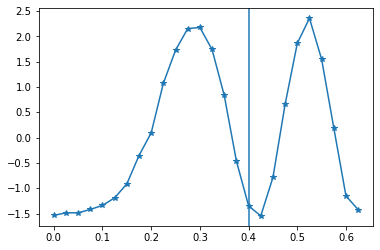

In [285]:
plot_Y = []
drive_powers = np.arange(0.0,0.65,0.025)
qubit = 8
print (qubit+1)
print (two_photon_rabi_codes[qubit])
job = backend.retrieve_job(two_photon_rabi_codes[qubit])
Rabi_results = job.result(timeout=3600)
    

plot_Y = []
for jj, drive_power in enumerate(drive_powers):
    thispower_results = Rabi_results.get_memory(jj)*scale_factor
    plot_Y.append( thispower_results[qubit] )

plot_X = drive_powers

plot_Y = plot_Y-np.mean(plot_Y)
plotter.plot(plot_X, get_amplitude(plot_Y),"-*")
plotter.axvline(0.4)

In [247]:
twop_pi = [0.2,0.18,0.55,0.1,0.1,0.52,0.15,0.2,0.29,0.0,0.3,0.2,0.22,0.2,0.2,0.2,0.2,0.2,0.2,0.4]
print (len(twop_rabi_pow_pi))

20


# T1 measurements

In [243]:
i=0

T1_experiment_qobj, T1_schedules, T1_schedule_LOs = T1_measurement(qubit_freq=two_photon_peak[i],pi_pulse_pow=0.2,pi_pulse_duration=128,time_max_us=500.0,time_step_us=2.0)

In [268]:
T1_codes = []

for i in range(20):
    qubit_freq = two_photon_peak[i]
    drive_qubit = [i]
    qubit_pow = twop_pi[i]

    print ("Submitting T1 Experiment on Qubit %s, at frequency %f GHz with power %f (arb)"%(drive_qubit,qubit_freq,qubit_pow))
    T1_experiment_qobj, T1_schedules, T1_schedule_LOs = T1_measurement(qubit=i, qubit_freq=two_photon_peak[i],pi_pulse_pow=twop_pi[i],pi_pulse_duration=128,time_max_us=500.0,time_step_us=2.0)
    job = backend.run(T1_experiment_qobj)
    T1_codes.append(job.job_id())

print (T1_codes)

Submitting T1 Experiment on Qubit [0], at frequency 4.894900 GHz with power 0.200000 (arb)
Submitting T1 Experiment on Qubit [1], at frequency 4.695297 GHz with power 0.180000 (arb)
Submitting T1 Experiment on Qubit [2], at frequency 4.552657 GHz with power 0.550000 (arb)
Submitting T1 Experiment on Qubit [3], at frequency 4.621331 GHz with power 0.100000 (arb)
Submitting T1 Experiment on Qubit [4], at frequency 4.207183 GHz with power 0.100000 (arb)
Submitting T1 Experiment on Qubit [5], at frequency 4.760607 GHz with power 0.520000 (arb)
Submitting T1 Experiment on Qubit [6], at frequency 4.573867 GHz with power 0.150000 (arb)
Submitting T1 Experiment on Qubit [7], at frequency 4.390024 GHz with power 0.200000 (arb)
Submitting T1 Experiment on Qubit [8], at frequency 4.504593 GHz with power 0.290000 (arb)
Submitting T1 Experiment on Qubit [9], at frequency 4.611633 GHz with power 0.000000 (arb)
Submitting T1 Experiment on Qubit [10], at frequency 4.802299 GHz with power 0.300000 (arb

250


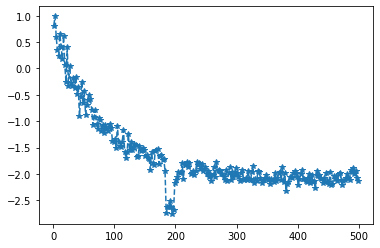

In [302]:
qubit = 1
job = backend.retrieve_job(T1_codes[qubit])
T1_results = job.result(timeout=3600)
time_max_us=500.0
time_step_us=2.0
times_us = np.arange(1, time_max_us, time_step_us)
print (len(times_us))
plot_X = times_us
plot_Y = []
for jj, delay_time_us in enumerate(times_us):
    thisdelay_results = T1_results.get_memory(jj)*scale_factor
    plot_Y.append( thisdelay_results[qubit] )

plotter.plot(plot_X, plot_Y,"--*")

WTF is that dip about?

250


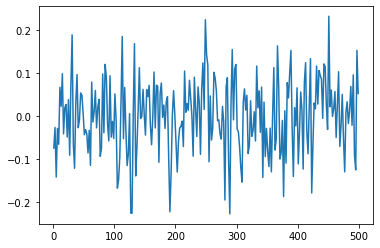

In [300]:
qubit = 19
job = backend.retrieve_job(T1_codes[qubit])
T1_results = job.result(timeout=3600)
time_max_us=500.0
time_step_us=2.0
times_us = np.arange(1, time_max_us, time_step_us)
print (len(times_us))
plot_X = times_us
plot_Y = []
for jj, delay_time_us in enumerate(times_us):
    thisdelay_results = T1_results.get_memory(jj)*scale_factor
    plot_Y.append( thisdelay_results[qubit] )

plotter.plot(plot_X, plot_Y)

T1 = 74.23507524950999 us
T1 from backend = 50.59515676617817 us


Text(0, 0.5, 'Measured signal, a.u.')

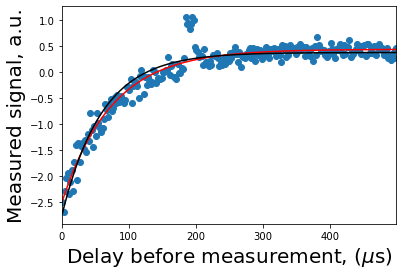

In [313]:
from scipy.optimize import curve_fit

fit_func = lambda x,A,T1,B: (A*np.exp(-x/T1)+B)
fit_func2 = lambda x,A,B: (A*np.exp(-x/59.8)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, plot_X,
                                      get_amplitude(plot_Y),
                                      [-1.0,50,-11])
fitparams2, conv2 = curve_fit(fit_func2, plot_X,
                                      get_amplitude(plot_Y),
                                      [-1.0,-11])

print(f"T1 = {fitparams[1]} us")
print(f"T1 from backend = {backend.properties().qubits[qubit][0].value} us")

plotter.scatter(plot_X, get_amplitude(plot_Y))
plotter.plot(plot_X, fit_func(plot_X, *fitparams), color='red')
plotter.plot(plot_X, fit_func2(plot_X, *fitparams2), color='black')
plotter.xlim(0, np.max(plot_X))
plotter.xlabel('Delay before measurement, ($\mu$s)', fontsize=20)
plotter.ylabel('Measured signal, a.u.', fontsize=20)

In [122]:
# from scipy.optimize import curve_fit

# fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

# #Fit the data
# fitparams, conv = curve_fit(fit_func, plot_X, plot_Y, [3.0  ,0.0  ,0.04  ,0])

# #get the pi amplitude
# first_peak = abs(np.pi-fitparams[3])*fitparams[2]/(2*np.pi)
# pi_amp = abs(fitparams[2]/2)

# plotter.scatter(plot_X, plot_Y)
# plotter.plot(plot_X, fit_func(plot_X, *fitparams), color='red')
# plotter.axvline(first_peak, color='black', linestyle='dashed')
# plotter.axvline(first_peak + pi_amp, color='black', linestyle='dashed')
# plotter.xlabel('Pulse amplitude, a.u.', fontsize=20)
# plotter.ylabel('Signal, a.u.', fontsize=20)
# plotter.title('Rough Pi Amplitude Calibration', fontsize=20)

# print('Pi Amplitude %f'%(pi_amp))

In [123]:
qubit_rabi_data = np.ones(num_Rabi_points, dtype=np.complex_)
for i in range(num_Rabi_points):
    qubit_rabi_data[i] = Rabi_results.get_memory(i)[qubit]*scale_factor
rabi_amp_data = get_amplitude(qubit_rabi_data)

In [124]:
saved_data = dict()
saved_data['rabi_amp_data'] = rabi_amp_data
saved_data['drive_amplitudes'] = drive_powers
saved_data['drive_samples'] = drive_samples
with open('rabi_exp_data_with_varying_drive_amplitudes.pkl', 'wb') as handle:
    pickle.dump(saved_data, handle)

In [125]:
with open('rabi_exp_data_with_varying_drive_amplitudes.pkl', 'rb') as handle:
    loaded_data = pickle.load(handle)
rabi_amp_data = loaded_data['rabi_amp_data']
drive_amps = loaded_data['drive_amplitudes']
drive_samples = loaded_data['drive_samples']

(0, 0.07)

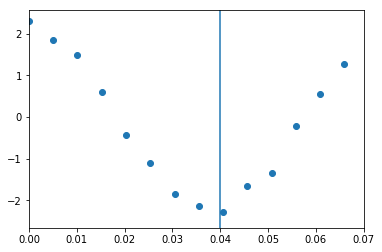

In [134]:
#rabi_amp_data = get_amplitude(qubit_rabi_data)

# fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

#Fit the data
# fitparams, conv = curve_fit(fit_func, drive_amps, rabi_amp_data, [1.0,0.0,0.02,0])

#get the pi amplitude
# pi_amp = (np.pi-fitparams[3])*fitparams[2]/2/np.pi

plt.scatter(drive_amps, rabi_amp_data)
plt.axvline(0.04)
# plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
# plt.axvline(pi_amp, color='black', linestyle='dashed')
plt.xlim(0, 0.07)
# # plt.ylim(-2, 2)
# plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
# plt.ylabel('Signal, a.u.', fontsize=20)
# plt.title('Rough Pi Amplitude Calibration', fontsize=20)

In [41]:
#### ^^^^^^^ Need to fix the rabi oscillation fit.   Not sure what is going wrong here

# Rabi Oscillation with varying duration

In [155]:
# Rabi experiment parameters
num_Rabi_points = 70
num_freq_points = 20
num_shots_per_point = 512
rough_frequency_qubit = backend_devicespec.q[qubit].drive
backend_defaults = backend.defaults()
rough_qubit_freq = backend_defaults.qubit_freq_est[qubit]
sig_ma = 0.006

# drive_frequencies = np.linspace(rough_frequency_qubit-sig_ma,rough_frequency_qubit+sig_ma,num_freq_points)

# drive parameters
duration_min = 4
duration_max = 60
drive_durations = np.array([int(i) for i in range(duration_min, duration_max, 1)])
drive_samples = 128
drive_sigma = 16
# Note: for codes[2] the max was 100 and steps of 2.
# For codes[3] the max was 60 and steps of 1. 5db86a45e440250018ba81a3

# create schedules for Rabi experiment 
Rabi_schedules = []
Rabi_schedule_LOs = []

mm=19
for ii, drive_duration in enumerate(drive_durations):
    rabi_pulse = pulse_lib.gaussian(duration=drive_duration, amp=0.1, 
                                    sigma=drive_sigma, name='rabi_pulse_{}'.format(ii))
    rabi_pulse_qubit = rabi_pulse(backend_devicespec.q[qubit].drive)
    # start an empty schedule with a label
    this_schedule = pulse.Schedule(name="Rabi drive = {}".format(drive_power))
    this_schedule += rabi_pulse_qubit
    this_schedule += measure_and_acquire_qubit << this_schedule.duration
    
    Rabi_schedules.append(this_schedule)
    thisLO = pulse.LoConfig({backend_devicespec.q[qubit].drive: rough_qubit_freq})
    Rabi_schedule_LOs.append(thisLO)
    
Rabi_schedules[-1].draw(channels_to_plot=[backend_devicespec.q[qubit].measure, 
                                           backend_devicespec.q[qubit].drive,
                                           #backend_devicespec.q[qubit].acquire,
                                         ],
                                         scaling=10.0)  

rabi_experiment_qobj = assemble (Rabi_schedules, backend = backend, 
                            meas_level=1, meas_return='avg',
                            shots=num_shots_per_point,
                            schedule_los = Rabi_schedule_LOs
                                )

# job = backend.run(rabi_experiment_qobj)
# onephonton_chevron_codes.append(job.job_id())

# print (onephonton_chevron_codes)

In [152]:
job.job_id()

'5db86a45e440250018ba81a3'

In [156]:
rabi_duration_drive_codes = ["5db76a49676a4200188da865","5db856749b911f001903c6a3","5db864bb889b23001aee5ec6","5db86a45e440250018ba81a3"] # First job was power 0.05.  Second was 0.01. Third 0.1 with 4-100 durations, steps of 2.






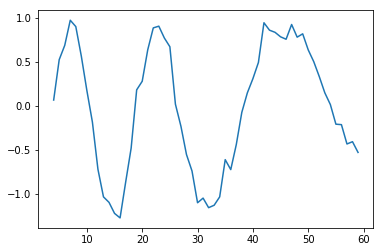

In [157]:
Y_plots= []
job = backend.retrieve_job(rabi_duration_drive_codes[3])
Rabi_results = job.result(timeout=3600)
    

plot_Y = []
for jj, drive_power in enumerate(drive_durations):
    thispower_results = Rabi_results.get_memory(jj)*scale_factor
    plot_Y.append( thispower_results[qubit] )
Y_plots.append(plot_Y)
plot_X = drive_durations
import matplotlib.pyplot as plotter
plot_Y = plot_Y-np.mean(plot_Y)
plotter.plot(plot_X, plot_Y)

In [158]:
qubit_rabi_data = np.ones(len(drive_durations), dtype=np.complex_)
for i in range(len(drive_durations)):
    qubit_rabi_data[i] = Rabi_results.get_memory(i)[qubit]*scale_factor
rabi_amp_data = get_amplitude(qubit_rabi_data)

In [159]:
saved_data = dict()
saved_data['rabi_amp_data'] = rabi_amp_data
saved_data['drive_amplitudes'] = drive_powers
saved_data['drive_samples'] = drive_samples
with open('rabi_exp_data_with_varying_drive_amplitudes.pkl', 'wb') as handle:
    pickle.dump(saved_data, handle)

In [160]:
with open('rabi_exp_data_with_varying_drive_amplitudes.pkl', 'rb') as handle:
    loaded_data = pickle.load(handle)
rabi_amp_data = loaded_data['rabi_amp_data']
drive_amps = loaded_data['drive_amplitudes']
drive_samples = loaded_data['drive_samples']

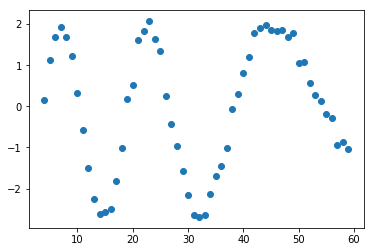

In [161]:
#rabi_amp_data = get_amplitude(qubit_rabi_data)

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, drive_durations, rabi_amp_data, [1.0,0.0,0.02,0])

#get the pi amplitude
pi_amp = (np.pi-fitparams[3])*fitparams[2]/2/np.pi

plt.scatter(drive_durations, rabi_amp_data)
# plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
# plt.axvline(pi_amp, color='black', linestyle='dashed')
# # plt.xlim(0, 0.05)
# # plt.ylim(-2, 2)
# plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
# plt.ylabel('Signal, a.u.', fontsize=20)
# plt.title('Rough Pi Amplitude Calibration', fontsize=20)

# 2 photon rabi

In [137]:
backend_devicespec

In [130]:
# Rabi experiment parameters
num_Rabi_points = 90
num_freq_points = 20
num_shots_per_point = 512
rough_frequency_qubit = backend_devicespec.q[qubit].drive
backend_defaults = backend.defaults()
rough_qubit_freq = 4.847297169266485
sig_ma = 0.006

# drive_frequencies = np.linspace(rough_frequency_qubit-sig_ma,rough_frequency_qubit+sig_ma,num_freq_points)

# drive parameters
drive_power_min = 0.0
drive_power_max = 0.3
drive_powers = np.linspace(drive_power_min, drive_power_max, num_Rabi_points)
drive_samples = 128
drive_sigma = 16

# create schedules for Rabi experiment 
Rabi_schedules = []
Rabi_schedule_LOs = []

mm=19
for ii, drive_power in enumerate(drive_powers):
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_power, 
                                    sigma=drive_sigma, name='rabi_pulse_{}'.format(ii))
    rabi_pulse_qubit = rabi_pulse(backend_devicespec.q[qubit].drive)
    
    # measurement pulse parameters
    meas_amp = 0.05
    meas_samples = 1200
    meas_sigma = 4
    meas_risefall = 25

    # creating measurement pulse
    meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                           sigma=meas_sigma, risefall=meas_risefall, 
                                           name='mymeasurepulse')
    meas_pulse_qubit = meas_pulse(backend_devicespec.q[qubit].measure)

    # create acquire pulse
    acq_cmd=pulse.Acquire(duration=meas_samples)
    acq_cmd_qubit = acq_cmd(backend_devicespec.q, backend_devicespec.mem)

    # combined measure and acquire pulse
    measure_and_acquire_qubit = meas_pulse_qubit | acq_cmd_qubit

    # scalefactor for received data
    scale_factor = 1e-10
    
    
    # start an empty schedule with a label
    this_schedule = pulse.Schedule(name="Rabi drive = {}".format(drive_power))
    this_schedule += rabi_pulse_qubit
    this_schedule += measure_and_acquire_qubit << this_schedule.duration
    
    Rabi_schedules.append(this_schedule)
    thisLO = pulse.LoConfig({backend_devicespec.q[qubit].drive: rough_qubit_freq})
    Rabi_schedule_LOs.append(thisLO)
    
Rabi_schedules[-1].draw(channels_to_plot=[backend_devicespec.q[qubit].measure, 
                                           backend_devicespec.q[qubit].drive,
                                           #backend_devicespec.q[qubit].acquire,
                                         ],
                                         scaling=10.0)  

rabi_experiment_qobj = assemble (Rabi_schedules, backend = backend, 
                            meas_level=1, meas_return='avg',
                            shots=num_shots_per_point,
                            schedule_los = Rabi_schedule_LOs
                                )

# job = backend.run(rabi_experiment_qobj)
# onephonton_chevron_codes.append(job.job_id())

# print (onephonton_chevron_codes)

In [121]:
job.job_id()

'5dcb0494f2b4ea001160716b'

In [123]:
twoprabi_codes = ["5dcafed81896660011bb280d","5dcb00cd0a67070011e8da43","5dcb0494f2b4ea001160716b"] #spot 1 should not do anything....lets see what happens

In [128]:
print (drive_powers)

[0.         0.0057971  0.0115942  0.0173913  0.02318841 0.02898551
 0.03478261 0.04057971 0.04637681 0.05217391 0.05797101 0.06376812
 0.06956522 0.07536232 0.08115942 0.08695652 0.09275362 0.09855072
 0.10434783 0.11014493 0.11594203 0.12173913 0.12753623 0.13333333
 0.13913043 0.14492754 0.15072464 0.15652174 0.16231884 0.16811594
 0.17391304 0.17971014 0.18550725 0.19130435 0.19710145 0.20289855
 0.20869565 0.21449275 0.22028986 0.22608696 0.23188406 0.23768116
 0.24347826 0.24927536 0.25507246 0.26086957 0.26666667 0.27246377
 0.27826087 0.28405797 0.28985507 0.29565217 0.30144928 0.30724638
 0.31304348 0.31884058 0.32463768 0.33043478 0.33623188 0.34202899
 0.34782609 0.35362319 0.35942029 0.36521739 0.37101449 0.37681159
 0.3826087  0.3884058  0.3942029  0.4       ]


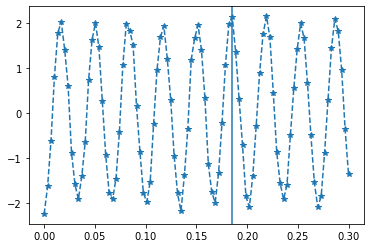

In [135]:
Y_plots= []
job = backend.retrieve_job(twoprabi_codes[2])
Rabi_results = job.result(timeout=3600)
    

plot_Y = []
for jj, drive_power in enumerate(drive_powers):
    thispower_results = Rabi_results.get_memory(jj)*scale_factor
    plot_Y.append( thispower_results[qubit] )
Y_plots.append(plot_Y)
plot_X = drive_powers

plot_Y = plot_Y-np.mean(plot_Y)
plotter.plot(plot_X, plot_Y,"--*")
plotter.axvline(0.185)

# IQ Plots

Okay, so the varying duration rabi pulses are behaving a bit oddly.   In the meantime lets see how we can do with the IQ plots (also, worth trying to get the IQ plots of the 2 state.  


Lets start off with defining a $\pi$ pulse.

In [226]:
drive_samples = 128
drive_sigma = 16
# pi_amp = 0.04
pi_amp = 0.185
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

In [227]:
# measurement pulse parameters
meas_amp = 0.2
meas_samples = 200
meas_sigma = 4
meas_risefall = 25

# creating measurement pulse
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples, amp=meas_amp,
                                       sigma=meas_sigma, risefall=meas_risefall, 
                                       name='mymeasurepulse')
meas_pulse_qubit = meas_pulse(backend_devicespec.q[qubit].measure)


# create acquire pulse
acq_cmd=pulse.Acquire(duration=meas_samples)
acq_cmd_qubit = acq_cmd(backend_devicespec.q, backend_devicespec.mem)

# combined measure and acquire pulse
measure_and_acquire_qubit = meas_pulse_qubit | acq_cmd_qubit



meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += drive_pulse(drive_chan)

# In a new schedule, which we will use again later, add a measurement stimulus on the
# measure channel pulse to trigger readout
measure_schedule = meas_pulse(meas_chan)
# Trigger data acquisition, and store classified values into respective memory slots
measure_schedule += acq_cmd([pulse.AcquireChannel(i) for i in backend_config.meas_map[meas_map_idx]],
                            [pulse.MemorySlot(i) for i in backend_config.meas_map[meas_map_idx]])
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure_schedule << schedule.duration


# Create the frequency settings for the sweep
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_GHz]

In [228]:
frequencies_GHz

array([4.691 , 4.6915, 4.692 , 4.6925, 4.693 , 4.6935, 4.694 , 4.6945,
       4.695 , 4.6955, 4.696 , 4.6965, 4.697 , 4.6975, 4.698 , 4.6985])

In [229]:
# Create two schedules for the Rabi experiment 
# Ground state schedule
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure_schedule

# Excited state schedule
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += pi_pulse(drive_chan)  # We found this in Part 2.A!
exc_schedule += measure_schedule << exc_schedule.duration

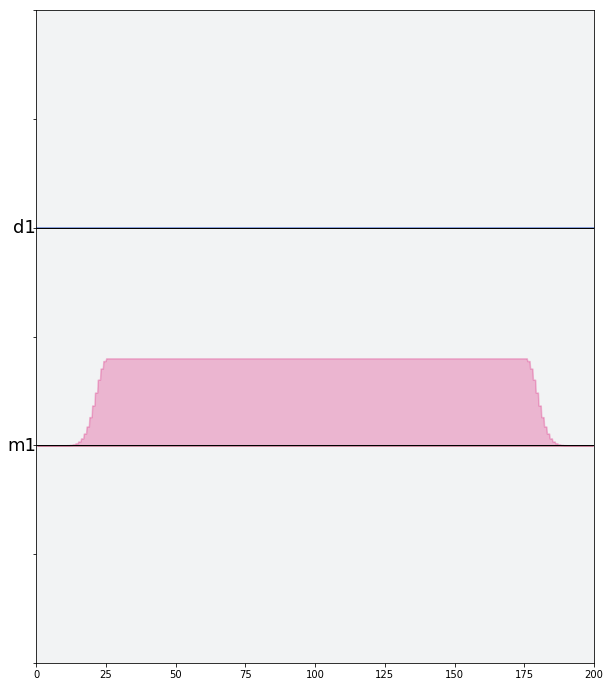

In [230]:
gnd_schedule.draw(channels_to_plot=[drive_chan, meas_chan], scaling=4.0)

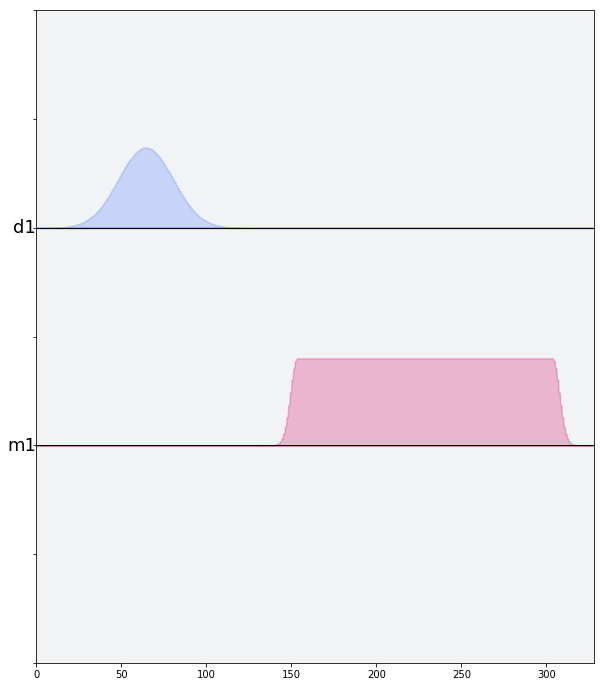

In [231]:
exc_schedule.draw(channels_to_plot=[drive_chan, meas_chan], scaling=4.0)

In [232]:
# Execution settings
num_shots = 1024
# rough_frequency_qubit = 4.847295222285821
rough_frequency_qubit = 4.6950
gnd_exc_program = assemble([gnd_schedule, exc_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_frequency_qubit}] * 2)

In [233]:
job = backend.run(gnd_exc_program)
print(job.job_id())
# job_monitor(job, quiet=False)

5dbc86486d90bb0018fb84f5


In [235]:
gnd_exc_codes = ["5db86fac99afd80019fc519a","5db87285889b23001aee5f64","5db872a199afd80019fc51ab","5db872bfe440250018ba81d3","5db875d7d3a8f10018a3e341"] #1200 , #200, #2000, #20000 (error), #10000

gnd_exc_codes_pow = ["5db8795361a7870019954124","5db87984f52ef7001ae785d4","5db879c583968b00193a3cde","5db879ddbb72de0018d8f1df","5db879f6d3a8f10018a3e36d"] #time fixed. 1200 samples   (above was power set to 0.05)sweeping power. #0.1, #0.2, #0.3, #0.01, #0.025

gnd_exc_codes2 = ["5db8b25ce440250018ba840b","5db8b2aebb72de0018d8f3e2","5db8b2c2889b23001aee6177","5db8b2e6d3a8f10018a3e589","5db8b314f52ef7001ae787f4","5db8b32cd3a8f10018a3e58c","5db8c296889b23001aee618a","5db8c2ced3a8f10018a3e5a5","5db8c2e6889b23001aee618c"] # power set to 0.1 and varying the duration: #200, #600, #1200, #2000, #5000, #10000, #300, #400, #500

gnd_f_codes = ["5dbb23fdcc27e40018397ac5"]
gnd_e_codes = ["5dbb28b5cc27e40018397adb"]

#Optimizing the qubit readout
#2000samp with 0.1pow, #1200 samp with 0.15 pow, #500 samples with 0.25 pow, #500 sam 0.15 pow, #200 sam 0.2 pow
g_e_codes = ["5dbc509bcc27e40018397e7a","5dbc544bcc27e40018397e86","5dbc55ff1af28c0018cca78e","5dbc5bb5cc27e40018397e99", "5dbc862123d1610018bf4ef0"] 
g_f_codes = ["5dbc50c823d1610018bf4e84","5dbc5410cc27e40018397e84","5dbc562626935800184e659b","5dbc5b8f084c3b00195c8d1b","5dbc86486d90bb0018fb84f5"] 

In [238]:
job = backend.retrieve_job(g_e_codes[-2])
gnd_e_results = job.result(timeout=3600)
job = backend.retrieve_job(g_f_codes[-2])
gnd_f_results = job.result(timeout=3600)

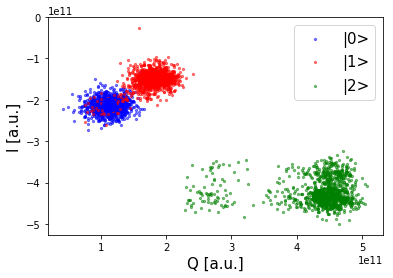

In [239]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]
exc_results = gnd_exc_results.get_memory(1)[:, qubit]
f_results = gnd_f_results.get_memory(1)[:, qubit]
import matplotlib.pyplot as plt

# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
#e states
plt.scatter(np.real(f_results), np.imag(e_results), 
                s=5, cmap='viridis', c='green', alpha=0.5, label='state_2')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
mean_f = np.mean(f_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='blue',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='red',alpha=1.0, label='state_1_mean')
plt.scatter(np.real(mean_f), np.imag(mean_f), 
            s=200, cmap='viridis', c='green',alpha=1.0, label='state_2_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.legend(["|0>","|1>","|2>"],fontsize=15)
plt.show()

# Getting prototypical chevrons

In [16]:
chevron_codes  =['5db8c50715a70b001967dcda', '5db8c51061a787001995434f', '5db8c51983968b00193a3f26', '5db8c520d3a8f10018a3e5ac', '5db8c525889b23001aee618e', '5db8c52a99afd80019fc53ec', '5db8c536f52ef7001ae7880d', '5db8c53ff52ef7001ae7880f', '5db8c544d3a8f10018a3e5ae', '5db8c54a15a70b001967dcdd', '5db8c54ef52ef7001ae78811', '5db8c55115a70b001967dcdf', '5db8c556d3a8f10018a3e5b0', '5db8c55b15a70b001967dce1', '5db8c560f52ef7001ae78813', '5db8c56461a7870019954351', '5db8c568889b23001aee6190', '5db8c56c99afd80019fc53ee', '5db8c57015a70b001967dce3', '5db8c57483968b00193a3f28', '5db8c578a693ee001877ed25', '5db8c57d99afd80019fc53f0', '5db8c581a693ee001877ed27', '5db8c587f52ef7001ae78815', '5db8c58c15a70b001967dce5', '5db8c59383968b00193a3f2a', '5db8c59883968b00193a3f2c', '5db8c59f15a70b001967dce8', '5db8c5a5a693ee001877ed29', '5db8c5ac83968b00193a3f2e', '5db8c5b2e440250018ba8424', '5db8c5b715a70b001967dceb', '5db8c5bce440250018ba8426', '5db8c5c2a693ee001877ed2b', '5db8c5c961a7870019954353', '5db8c5ce61a7870019954355', '5db8c5d3f52ef7001ae78817', '5db8c5dabb72de0018d8f3fb', '5db8c5de99afd80019fc53f3', '5db8c5e4a693ee001877ed2f']
qubit_rabi_frequencies = [4.8412952222858205, 4.841602914593513, 4.841910606901205, 4.842218299208898, 4.84252599151659, 4.842833683824282, 4.843141376131975, 4.843449068439667, 4.843756760747359, 4.844064453055052, 4.844372145362744, 4.844679837670436, 4.844987529978129, 4.845295222285821, 4.845602914593513, 4.845910606901206, 4.846218299208898, 4.84652599151659, 4.846833683824283, 4.847141376131975, 4.8474490684396665, 4.847756760747359, 4.848064453055051, 4.8483721453627435, 4.848679837670436, 4.848987529978128, 4.8492952222858206, 4.849602914593513, 4.849910606901205, 4.850218299208898, 4.85052599151659, 4.850833683824282, 4.851141376131975, 4.851449068439667, 4.851756760747359, 4.852064453055052, 4.852372145362744, 4.852679837670436, 4.852987529978129, 4.853295222285821]

In [40]:
# Rabi experiment parameters
num_Rabi_points = 70
num_freq_points = 40
num_shots_per_point = 512
backend_defaults = backend.defaults()
rough_qubit_freq = backend_defaults.qubit_freq_est[qubit]
sig_ma = 0.006

drive_frequencies = np.linspace(rough_qubit_freq-sig_ma,rough_qubit_freq+sig_ma,num_freq_points)

# drive parameters
duration_min = 4
duration_max = 60
drive_durations = np.array([int(i) for i in range(duration_min, duration_max, 1)])
drive_samples = 128
drive_sigma = 16
# Note: for codes[2] the max was 100 and steps of 2.
# For codes[3] the max was 60 and steps of 1. 5db86a45e440250018ba81a3

# create schedules for Rabi experiment 
Rabi_schedules = []
Rabi_schedule_LOs = []

mm=39
for ii, drive_duration in enumerate(drive_durations):
    rabi_pulse = pulse_lib.gaussian(duration=drive_duration, amp=0.1, 
                                    sigma=drive_sigma, name='rabi_pulse_{}'.format(ii))
    rabi_pulse_qubit = rabi_pulse(backend_devicespec.q[qubit].drive)
    # start an empty schedule with a label
    this_schedule = pulse.Schedule(name="Rabi drive = {}".format(drive_power))
    this_schedule += rabi_pulse_qubit
    this_schedule += measure_and_acquire_qubit << this_schedule.duration
    
    Rabi_schedules.append(this_schedule)
    thisLO = pulse.LoConfig({backend_devicespec.q[qubit].drive: drive_frequencies[mm]})
    Rabi_schedule_LOs.append(thisLO)
    


rabi_experiment_qobj = assemble (Rabi_schedules, backend = backend, 
                            meas_level=1, meas_return='avg',
                            shots=num_shots_per_point,
                            schedule_los = Rabi_schedule_LOs
                                )

# job = backend.run(rabi_experiment_qobj)
# job_code =  job.job_id()
print (chevron_codes)
print (qubit_rabi_frequencies)

['5db8c50715a70b001967dcda', '5db8c51061a787001995434f', '5db8c51983968b00193a3f26', '5db8c520d3a8f10018a3e5ac', '5db8c525889b23001aee618e', '5db8c52a99afd80019fc53ec', '5db8c536f52ef7001ae7880d', '5db8c53ff52ef7001ae7880f', '5db8c544d3a8f10018a3e5ae', '5db8c54a15a70b001967dcdd', '5db8c54ef52ef7001ae78811', '5db8c55115a70b001967dcdf', '5db8c556d3a8f10018a3e5b0', '5db8c55b15a70b001967dce1', '5db8c560f52ef7001ae78813', '5db8c56461a7870019954351', '5db8c568889b23001aee6190', '5db8c56c99afd80019fc53ee', '5db8c57015a70b001967dce3', '5db8c57483968b00193a3f28', '5db8c578a693ee001877ed25', '5db8c57d99afd80019fc53f0', '5db8c581a693ee001877ed27', '5db8c587f52ef7001ae78815', '5db8c58c15a70b001967dce5', '5db8c59383968b00193a3f2a', '5db8c59883968b00193a3f2c', '5db8c59f15a70b001967dce8', '5db8c5a5a693ee001877ed29', '5db8c5ac83968b00193a3f2e', '5db8c5b2e440250018ba8424', '5db8c5b715a70b001967dceb', '5db8c5bce440250018ba8426', '5db8c5c2a693ee001877ed2b', '5db8c5c961a7870019954353', '5db8c5ce61a7870019

In [33]:
Y_plots= []
for k in range(len(chevron_codes)):
    job = backend.retrieve_job(chevron_codes[k])
    Rabi_results = job.result(timeout=3600)
    

    plot_Y = []
    for jj, drive_duration in enumerate(drive_durations):
        thispower_results = Rabi_results.get_memory(jj)*scale_factor
        plot_Y.append( thispower_results[qubit] )
    Y_plots.append(plot_Y)

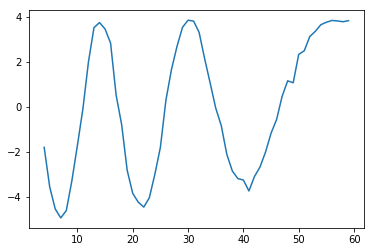

In [38]:
plot_X = drive_durations
import matplotlib.pyplot as plotter
plot_Ynew = get_amplitude(plot_Y)
plot_Y = plot_Y - np.mean(plot_Y)
plotter.plot(plot_X, plot_Ynew)

40


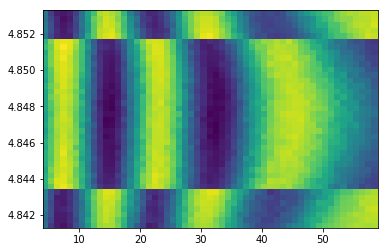

In [41]:
Y_amp_plots = []
for i in range(len(Y_plots)):
    Y_amp_plots.append(get_amplitude(Y_plots[i]))
print (len(Y_amp_plots))
plotter.pcolormesh(drive_durations,qubit_rabi_frequencies, Y_amp_plots)

# Chevron pattern with power on x-axis

In [20]:
pow_chevron_codes = ['5db8c6b6889b23001aee6198', '5db8c6cbf52ef7001ae7881b', '5db8c6d2f52ef7001ae7881d', '5db8c6d6f52ef7001ae7881f', '5db8c6eb99afd80019fc53f7', '5db8c6f699afd80019fc53f9', '5db8c6fc83968b00193a3f30', '5db8c704889b23001aee619a', '5db8c70761a787001995435b', '5db8c70c99afd80019fc53fb', '5db8c710bb72de0018d8f401', '5db8c71361a787001995435d', '5db8c716e440250018ba842d', '5db8c71a99afd80019fc53fe', '5db8c71df52ef7001ae78821', '5db8c721f52ef7001ae78823', '5db8c725a693ee001877ed32', '5db8c72861a787001995435f', '5db8c72ba693ee001877ed34', '5db8c72fd3a8f10018a3e5b4', '5db8c732a693ee001877ed36', '5db8c73615a70b001967dcf1', '5db8c73b61a7870019954361', '5db8c73f61a7870019954363', '5db8c742889b23001aee619d', '5db8c74699afd80019fc5400', '5db8c749889b23001aee619f', '5db8c74ce440250018ba842f', '5db8c74f15a70b001967dcf3', '5db8c75383968b00193a3f32', '5db8c76715a70b001967dcf5', '5db8c76dbb72de0018d8f403', '5db8c770f52ef7001ae78825', '5db8c77461a7870019954365', '5db8c778a693ee001877ed38', '5db8c77ca693ee001877ed3a', '5db8c782bb72de0018d8f406', '5db8c78599afd80019fc5402', '5db8c789e440250018ba8431', '5db8c78de440250018ba8433']
qubit_pow_rabi_frequencies = [4.8412952222858205, 4.841602914593513, 4.841910606901205, 4.842218299208898, 4.84252599151659, 4.842833683824282, 4.843141376131975, 4.843449068439667, 4.843756760747359, 4.844064453055052, 4.844372145362744, 4.844679837670436, 4.844987529978129, 4.845295222285821, 4.845602914593513, 4.845910606901206, 4.846218299208898, 4.84652599151659, 4.846833683824283, 4.847141376131975, 4.8474490684396665, 4.847756760747359, 4.848064453055051, 4.8483721453627435, 4.848679837670436, 4.848987529978128, 4.8492952222858206, 4.849602914593513, 4.849910606901205, 4.850218299208898, 4.85052599151659, 4.850833683824282, 4.851141376131975, 4.851449068439667, 4.851756760747359, 4.852064453055052, 4.852372145362744, 4.852679837670436, 4.852987529978129, 4.853295222285821]

In [21]:
# Rabi experiment parameters
num_Rabi_points = 70
num_freq_points = 40
num_shots_per_point = 512
backend_defaults = backend.defaults()
rough_qubit_freq = backend_defaults.qubit_freq_est[qubit]
sig_ma = 0.006

drive_frequencies = np.linspace(rough_qubit_freq-sig_ma,rough_qubit_freq+sig_ma,num_freq_points)

# drive parameters
drive_power_min = 0.0
drive_power_max = 0.15
drive_powers = np.linspace(drive_power_min, drive_power_max, num_Rabi_points)
drive_samples = 128
drive_sigma = 16

# create schedules for Rabi experiment 
Rabi_schedules = []
Rabi_schedule_LOs = []

mm=39
for ii, drive_power in enumerate(drive_powers):
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_power, 
                                    sigma=drive_sigma, name='rabi_pulse_{}'.format(ii))
    rabi_pulse_qubit = rabi_pulse(backend_devicespec.q[qubit].drive)
    # start an empty schedule with a label
    this_schedule = pulse.Schedule(name="Rabi drive = {}".format(drive_power))
    this_schedule += rabi_pulse_qubit
    this_schedule += measure_and_acquire_qubit << this_schedule.duration
    
    Rabi_schedules.append(this_schedule)
    thisLO = pulse.LoConfig({backend_devicespec.q[qubit].drive: drive_frequencies[mm]})
    Rabi_schedule_LOs.append(thisLO)
    

rabi_experiment_qobj = assemble (Rabi_schedules, backend = backend, 
                            meas_level=1, meas_return='avg',
                            shots=num_shots_per_point,
                            schedule_los = Rabi_schedule_LOs
                                )

# job = backend.run(rabi_experiment_qobj)
# job_code =  job.job_id()
print (pow_chevron_codes)
print (qubit_pow_rabi_frequencies)

['5db8c6b6889b23001aee6198', '5db8c6cbf52ef7001ae7881b', '5db8c6d2f52ef7001ae7881d', '5db8c6d6f52ef7001ae7881f', '5db8c6eb99afd80019fc53f7', '5db8c6f699afd80019fc53f9', '5db8c6fc83968b00193a3f30', '5db8c704889b23001aee619a', '5db8c70761a787001995435b', '5db8c70c99afd80019fc53fb', '5db8c710bb72de0018d8f401', '5db8c71361a787001995435d', '5db8c716e440250018ba842d', '5db8c71a99afd80019fc53fe', '5db8c71df52ef7001ae78821', '5db8c721f52ef7001ae78823', '5db8c725a693ee001877ed32', '5db8c72861a787001995435f', '5db8c72ba693ee001877ed34', '5db8c72fd3a8f10018a3e5b4', '5db8c732a693ee001877ed36', '5db8c73615a70b001967dcf1', '5db8c73b61a7870019954361', '5db8c73f61a7870019954363', '5db8c742889b23001aee619d', '5db8c74699afd80019fc5400', '5db8c749889b23001aee619f', '5db8c74ce440250018ba842f', '5db8c74f15a70b001967dcf3', '5db8c75383968b00193a3f32', '5db8c76715a70b001967dcf5', '5db8c76dbb72de0018d8f403', '5db8c770f52ef7001ae78825', '5db8c77461a7870019954365', '5db8c778a693ee001877ed38', '5db8c77ca693ee0018

In [42]:
Y_plots= []
for k in range(len(pow_chevron_codes)):
    job = backend.retrieve_job(pow_chevron_codes[k])
    Rabi_results = job.result(timeout=3600)
    

    plot_Y = []
    for jj, drive_power in enumerate(drive_powers):
        thispower_results = Rabi_results.get_memory(jj)*scale_factor
        plot_Y.append( thispower_results[qubit] )
    Y_plots.append(plot_Y)

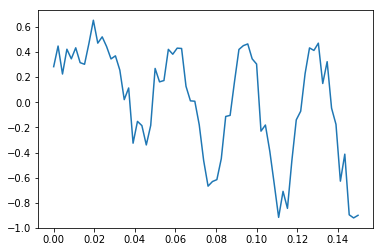

In [43]:
plot_X = drive_powers
plot_Ynew = get_amplitude(plot_Y)
plot_Y = plot_Y - np.mean(plot_Y)
plotter.plot(plot_X, plot_Ynew)

40


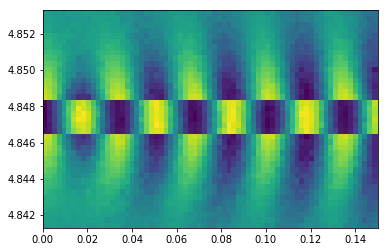

In [46]:
Y_amp_plots = []
for i in range(len(Y_plots)):
    Y_amp_plots.append(get_amplitude(Y_plots[i]))
print (len(Y_amp_plots))
plotter.pcolormesh(drive_powers,qubit_rabi_frequencies, Y_amp_plots)